In [ ]:
# encoding=utf-8

import json
import os
import random
from argparse import ArgumentParser

import albumentations as A
import annoy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import StratifiedGroupKFold
from tqdm import tqdm


def train_val_split(df, fold, seed=42):
    df = df.merge(
        df["artistid"].value_counts(),
        left_on="artistid",
        right_index=True,
        suffixes=[None, "_count"],
    )
    gkf = StratifiedGroupKFold(n_splits=8, shuffle=True, random_state=seed)
    for n, (train_ids, val_ids) in enumerate(
        gkf.split(
            X=df[["artistid", "artistid_count"]],
            y=df["artistid_count"],
            groups=df["artistid"],
        )
    ):
        df.loc[val_ids, "fold"] = n
    train_df = df[df["fold"] != fold].reset_index(drop=True).copy()
    val_df = df[df["fold"] == fold].reset_index(drop=True).copy()
    return train_df, val_df


class FeaturesLoader:
    def __init__(
        self, features_dir_path, meta_info, device="cpu", test=False, crop_size=60
    ):
        self.features_dir_path = features_dir_path
        self.meta_info = meta_info
        self.trackid2path = meta_info.set_index("trackid")[
            "archive_features_path"
        ].to_dict()
        self.crop_size = crop_size
        self.device = device
        self.test = test

    def augment(self, img):
        transform = A.Compose(
            [
                A.RandomCrop(always_apply=True, p=1.0, height=512, width=60),
                A.Flip(p=0.2),
                A.PixelDropout(p=0.1, dropout_prob=0.01),
                A.CoarseDropout(
                    p=0.1,
                    max_holes=11,
                    max_height=5,
                    max_width=3,
                    min_holes=1,
                    min_height=2,
                    min_width=2,
                ),
                A.RandomGridShuffle(p=0.3, grid=(1, 6)),
            ]
        )
        return transform(image=img)["image"]

    def _load_item(self, track_id):
        track_features_file_path = self.trackid2path[track_id]
        img = np.load(os.path.join(self.features_dir_path, track_features_file_path))
        if self.test:
            padding = (img.shape[1] - self.crop_size) // 2
            img = img[:, padding : padding + self.crop_size]
        else:
            img = self.augment(img)
        return img

    def load_batch(self, tracks_ids):
        batch = [self._load_item(track_id) for track_id in tracks_ids]
        return torch.tensor(np.array(batch)).to(self.device)


class TrainLoader:
    def __init__(self, features_loader, batch_size=256, features_size=(512, 60)):
        self.features_loader = features_loader
        self.batch_size = batch_size
        self.features_size = features_size
        self.artist_track_ids = self.features_loader.meta_info.groupby("artistid").agg(
            list
        )

    def _generate_pairs(self, track_ids):
        np.random.shuffle(track_ids)
        pairs = [track_ids[i - 2 : i] for i in range(2, len(track_ids) + 1, 2)]
        return pairs

    def _get_pair_ids(self):
        pairs = []
        artist_track_ids = self.artist_track_ids.copy()
        artist_track_pairs = artist_track_ids["trackid"].map(self._generate_pairs)
        for pair_ids in artist_track_pairs.explode().dropna():
            pairs.append(pair_ids)
        np.random.shuffle(pairs)
        return pairs

    def _get_batch(self, batch_ids):
        batch_ids = np.array(batch_ids).reshape(-1)
        batch_features = self.features_loader.load_batch(batch_ids)
        batch_features = batch_features.reshape(self.batch_size, 2, *self.features_size)
        return batch_features

    def __iter__(self):
        batch_ids = []
        for pair_ids in self._get_pair_ids():
            batch_ids.append(pair_ids)
            if len(batch_ids) == self.batch_size:
                batch = self._get_batch(batch_ids)
                yield batch
                batch_ids = []

    def _len(self):
        return sum(1 for x in self._get_pair_ids()) // self.batch_size


class TestLoader:
    def __init__(self, features_loader, batch_size=256, features_size=(512, 60)):
        self.features_loader = features_loader
        self.batch_size = batch_size
        self.features_size = features_size

    def __iter__(self):
        batch_ids = []
        for track_id in tqdm(self.features_loader.meta_info["trackid"].values):
            batch_ids.append(track_id)
            if len(batch_ids) == self.batch_size:
                yield batch_ids, self.features_loader.load_batch(batch_ids)
                batch_ids = []
        if len(batch_ids) > 0:
            yield batch_ids, self.features_loader.load_batch(batch_ids)


class NT_Xent(nn.Module):
    def __init__(self, temperature):
        super(NT_Xent, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        N = 2 * batch_size
        z = torch.cat((z_i, z_j), dim=0)
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, -batch_size)

        mask = self.mask_correlated_samples(batch_size)
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_samples.device).long()
        labels[0] = 1
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss


def get_ranked_list(embeds, top_size, annoy_num_trees=128):
    annoy_index = None
    annoy2id = []
    id2annoy = dict()
    for track_id, track_embed in tqdm(embeds.items()):
        id2annoy[track_id] = len(annoy2id)
        annoy2id.append(track_id)
        if annoy_index is None:
            annoy_index = annoy.AnnoyIndex(len(track_embed), "angular")
        annoy_index.add_item(id2annoy[track_id], track_embed)
    annoy_index.build(annoy_num_trees, n_jobs=-1)
    ranked_list = dict()
    for track_id in tqdm(embeds.keys()):
        candidates = annoy_index.get_nns_by_item(id2annoy[track_id], top_size + 1)[
            1:
        ]  # exclude trackid itself
        candidates = list(filter(lambda x: x != id2annoy[track_id], candidates))
        ranked_list[track_id] = [annoy2id[candidate] for candidate in candidates]
    return ranked_list


def position_discounter(position):
    return 1.0 / np.log2(position + 1)


def get_ideal_dcg(relevant_items_count, top_size):
    dcg = 0.0
    for result_indx in range(min(top_size, relevant_items_count)):
        position = result_indx + 1
        dcg += position_discounter(position)
    return dcg


def compute_dcg(query_trackid, ranked_list, track2artist_map, top_size):
    query_artistid = track2artist_map[query_trackid]
    dcg = 0.0
    for result_indx, result_trackid in enumerate(ranked_list[:top_size]):
        assert result_trackid != query_trackid
        position = result_indx + 1
        discounted_position = position_discounter(position)
        result_artistid = track2artist_map[result_trackid]
        if result_artistid == query_artistid:
            dcg += discounted_position
    return dcg


def eval_submission(submission, gt_meta_info, top_size=100):
    track2artist_map = gt_meta_info.set_index("trackid")["artistid"].to_dict()
    artist2tracks_map = gt_meta_info.groupby("artistid").agg(list)["trackid"].to_dict()
    ndcg_list = []
    for query_trackid in tqdm(submission.keys()):
        ranked_list = submission[query_trackid]
        query_artistid = track2artist_map[query_trackid]
        query_artist_tracks_count = len(artist2tracks_map[query_artistid])
        ideal_dcg = get_ideal_dcg(query_artist_tracks_count - 1, top_size=top_size)
        dcg = compute_dcg(
            query_trackid, ranked_list, track2artist_map, top_size=top_size
        )
        try:
            ndcg_list.append(dcg / ideal_dcg)
        except ZeroDivisionError:
            continue
    return np.mean(ndcg_list)


# Train & Inference functions


class BasicNet(nn.Module):
    def __init__(
        self, output_features_size1=512, output_features_size2=128, kernel_size=3
    ):
        super().__init__()
        self.output_features_size = output_features_size1 + output_features_size2
        self.conv_1 = nn.Conv1d(
            512, output_features_size1, kernel_size=kernel_size, padding=1
        )
        self.conv_2 = nn.Conv1d(
            output_features_size1,
            output_features_size1,
            kernel_size=kernel_size,
            padding=1,
        )
        self.mp_1 = nn.MaxPool1d(2, 2)
        # self.conv_3 = nn.Conv1d(output_features_size1, output_features_size1, kernel_size=kernel_size, padding=1)
        # self.conv_4 = nn.Conv1d(output_features_size1, output_features_size1, kernel_size=kernel_size, padding=1)

        self.conv_1_2 = nn.Conv1d(
            60, output_features_size2, kernel_size=kernel_size, padding=1
        )
        self.conv_2_2 = nn.Conv1d(
            output_features_size2,
            output_features_size2,
            kernel_size=kernel_size,
            padding=1,
        )
        self.mp_1_2 = nn.MaxPool1d(2, 2)
        # self.conv_3_2 = nn.Conv1d(output_features_size2, output_features_size2, kernel_size=kernel_size, padding=1)
        # self.conv_4_2 = nn.Conv1d(output_features_size2, output_features_size2, kernel_size=kernel_size, padding=1)

    def forward(self, x):
        y = x.transpose(2, 1)
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = self.mp_1(x).mean(axis=2)
        # x = F.relu(self.conv_3(x))
        # x = self.conv_4(x)

        y = F.relu(self.conv_1_2(y))
        y = F.relu(self.conv_2_2(y))
        y = self.mp_1_2(y).mean(axis=2)
        #         y = F.relu(self.conv_3_2(y))
        #         y = self.conv_4_2(y)

        return torch.cat([x, y], axis=-1)


class SimCLR(nn.Module):
    def __init__(self, encoder, projection_dim):
        super().__init__()
        self.encoder = encoder
        self.n_features = encoder.output_features_size
        self.projection_dim = projection_dim
        self.projector = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.ReLU(),
            nn.Linear(self.n_features, self.projection_dim, bias=False),
        )

    def forward(self, x_i, x_j):
        h_i = self.encoder(x_i)
        h_j = self.encoder(x_j)

        z_i = self.projector(h_i)
        z_j = self.projector(h_j)
        return h_i, h_j, z_i, z_j


class SimCLR_infer(nn.Module):
    def __init__(self, encoder, projection_dim):
        super().__init__()
        self.encoder = encoder
        self.n_features = encoder.output_features_size
        self.projection_dim = projection_dim
        self.projector = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.ReLU(),
            nn.Linear(self.n_features, self.projection_dim, bias=False),
        )

    def forward(
        self,
        x,
    ):
        x = self.encoder(x)
        x = self.projector(x)
        return x


def inference(model, loader):
    embeds = dict()
    for tracks_ids, tracks_features in loader:
        with torch.no_grad():
            tracks_embeds = model(tracks_features)
            for track_id, track_embed in zip(tracks_ids, tracks_embeds):
                embeds[track_id] = track_embed.cpu().numpy()
    return embeds


class EarlyStopper:
    def __init__(self, patience=5, min_delta=1e-6):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_metric = 0

    def early_stop(self, validation_metric):
        if validation_metric > self.min_validation_metric:
            self.min_validation_metric = validation_metric
            self.counter = 0
        elif validation_metric < (self.min_validation_metric + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


def train(
    module,
    train_loader,
    val_loader,
    valset_meta,
    optimizer,
    criterion,
    num_epochs,
    checkpoint_path,
    module_path,
    history_path,
    top_size=100,
):
    max_enc_ndcg, max_proj_ndcg = None, None
    best_enc_epoch, best_proj_epoch = 0, 0
    metrics = {"train_loss": [], "encoder": [], "projector": []}
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=4, verbose=True
    )
    early_stopper = EarlyStopper(patience=17)
    for epoch in range(num_epochs):
        train_bar = tqdm(
            enumerate(train_loader),
            total=train_loader._len(),
            desc=f"Train: epoch #{epoch + 1}/{num_epochs}",
        )
        running_loss = 0
        epoch_loss = 0
        for n, batch in train_bar:
            optimizer.zero_grad()
            module.train()
            x_i, x_j = batch[:, 0, :, :], batch[:, 1, :, :]
            h_i, h_j, z_i, z_j = module(x_i, x_j)
            loss = criterion(z_i, z_j)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss = running_loss / (n + 1)
            current_lr = optimizer.param_groups[0]["lr"]
            memory = (
                torch.cuda.memory_reserved() / 1e9 if torch.cuda.is_available() else 0
            )
            train_bar.set_postfix(
                train_loss=f"{epoch_loss:0.4f}",
                lr=f"{current_lr:0.6f}",
                gpu_memory=f"{memory:0.2f} GB",
            )
        metrics["train_loss"].append(epoch_loss)

        with torch.no_grad():
            print("\nValidation nDCG on epoch {}".format(epoch + 1))
            # model_encoder = module.encoder
            # embeds_encoder = inference(model_encoder, val_loader)
            # ranked_list_encoder = get_ranked_list(embeds_encoder, top_size)
            # val_ndcg_encoder = eval_submission(ranked_list_encoder, valset_meta)
            # print("Encoder - {}".format(val_ndcg_encoder))
            # metrics["encoder"].append(val_ndcg_encoder)
            # if (max_enc_ndcg is None) or (val_ndcg_encoder > max_enc_ndcg):
            #     print(f"encoder ndcg improved from {max_enc_ndcg} to {val_ndcg_encoder}, checkpoints saved to {checkpoint_path}")
            #     max_enc_ndcg = val_ndcg_encoder
            #     best_enc_epoch = epoch
            #     torch.save(model_encoder.state_dict(), checkpoint_path)

            model_projector = nn.Sequential(module.encoder, module.projector)
            embeds_projector = inference(model_projector, val_loader)
            ranked_list_projector = get_ranked_list(embeds_projector, top_size, 128)
            val_ndcg_projector = eval_submission(ranked_list_projector, valset_meta)
            metrics["projector"].append(val_ndcg_projector)
            print(f"Projector_ndcg = {val_ndcg_projector} at {epoch + 1} epoch")
            if (max_proj_ndcg is None) or (val_ndcg_projector > max_proj_ndcg):
                print(
                    f"projector ndcg improved from {max_proj_ndcg} to {val_ndcg_projector}, checkpoints saved to {module_path}"
                )
                max_proj_ndcg = val_ndcg_projector
                best_proj_epoch = epoch
                torch.save(module.state_dict(), module_path)

            scheduler.step(val_ndcg_projector)
            if early_stopper.early_stop(val_ndcg_projector):
                break
    with open(os.path.join(history_path, "history.json"), "w") as f:
        json.dump(metrics, f)
    # print(f"Best encoder_ndcg = {max_enc_ndcg} at {best_enc_epoch} epoch")
    print(f"Best projector_ndcg = {max_proj_ndcg} at {best_proj_epoch} epoch\n")


def save_submission(submission, submission_path, top=100):
    with open(submission_path, "w") as f:
        for query_trackid, result in submission.items():
            f.write("{}\t{}\n".format(query_trackid, " ".join(map(str, result[:top]))))


def main():
    parser = ArgumentParser(description="Simple naive baseline")
    parser.add_argument(
        "--base-dir",
        dest="base_dir",
        action="store",
        required=False,
        type=str,
        nargs="?",
        const="/app/_data/artist_data/",
        default="/app/_data/artist_data/",
    )
    parser.add_argument(
        "--save-dir", dest="save_dir", action="store", required=True, type=str
    )
    parser.add_argument(
        "--fold",
        dest="fold",
        action="store",
        required=False,
        nargs="?",
        const=0,
        type=int,
        default=0,
    )
    parser.add_argument(
        "--batch-size",
        dest="batch_size",
        action="store",
        required=False,
        nargs="?",
        const=512,
        type=int,
        default=512,
    )
    parser.add_argument(
        "--n-chanels",
        dest="n_chahels",
        action="store",
        required=False,
        nargs="?",
        const=256,
        type=int,
        default=256,
    )
    parser.add_argument(
        "--proj-dim",
        dest="proj_dim",
        action="store",
        required=False,
        nargs="?",
        const=128,
        type=int,
        default=128,
    )
    parser.add_argument(
        "--kernel-size",
        dest="kernel_size",
        action="store",
        required=False,
        nargs="?",
        const=3,
        type=int,
        default=3,
    )
    parser.add_argument(
        "--n-epochs",
        dest="n_epochs",
        action="store",
        required=False,
        nargs="?",
        const=150,
        type=int,
        default=150,
    )
    parser.add_argument(
        "--temperature",
        dest="temperature",
        action="store",
        required=False,
        nargs="?",
        const=0.01,
        type=float,
        default=0.01,
    )
    args = parser.parse_args()

    # python3 ny_baseline.py --base-dir='/app/_data/artist_data/' --save-dir='ny_2_1' --fold=1 --batch-size=512 --n-chanels=512 --proj-dim=256 --n-epochs=150 --kernel-size=3 --temperature=0.001
    # Seed
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    TRAINSET_DIRNAME = "train_features"
    TESTSET_DIRNAME = "test_features"
    TRAINSET_META_FILENAME = "train_meta.tsv"
    TESTSET_META_FILENAME = "test_meta.tsv"
    SUBMISSION_FILENAME = "submission.txt"
    MODEL_FILENAME = "model.pt"
    CHECKPOINT_FILENAME = "best.pt"
    MODULE_FILENAME = "best_module.pt"
    device = "cuda" if torch.cuda.is_available() else "cpu"

    BATCH_SIZE = args.batch_size
    N_CHANNELS = args.n_chahels
    PROJECTION_DIM = args.proj_dim
    KERNEL_SIZE = args.kernel_size
    NUM_EPOCHS = args.n_epochs
    FOLD = args.fold
    LR = 1e-4
    TEMPERATURE = args.temperature

    TRAINSET_PATH = os.path.join(args.base_dir, TRAINSET_DIRNAME)
    TESTSET_PATH = os.path.join(args.base_dir, TESTSET_DIRNAME)
    TRAINSET_META_PATH = os.path.join(args.base_dir, TRAINSET_META_FILENAME)
    TESTSET_META_PATH = os.path.join(args.base_dir, TESTSET_META_FILENAME)
    BASE_DIR = os.path.join(args.base_dir, "subm_mod", args.save_dir)
    SUBMISSION_PATH = os.path.join(BASE_DIR, SUBMISSION_FILENAME)
    MODEL_PATH = os.path.join(BASE_DIR, MODEL_FILENAME)
    CHECKPOINT_PATH = os.path.join(BASE_DIR, CHECKPOINT_FILENAME)
    MODULE_PATH = os.path.join(BASE_DIR, MODULE_FILENAME)
    if not os.path.exists(BASE_DIR):
        os.makedirs(BASE_DIR)

    with open(
        os.path.join(args.base_dir, "subm_mod", args.save_dir, "args.json"), "w"
    ) as f:
        json.dump(args.__dict__, f)

    sim_clr = SimCLR(
        encoder=BasicNet(N_CHANNELS, KERNEL_SIZE), projection_dim=PROJECTION_DIM
    ).to(device)
    # if os.path.exists(MODULE_PATH):
    #     weights = torch.load(MODULE_PATH)
    #     sim_clr.load_state_dict(weights)

    train_meta_info = pd.read_csv(TRAINSET_META_PATH, sep="\t")
    test_meta_info = pd.read_csv(TESTSET_META_PATH, sep="\t")
    train_meta_info, validation_meta_info = train_val_split(
        train_meta_info, fold=FOLD, seed=seed
    )

    print("Loaded data")
    print("Train set size: {}".format(len(train_meta_info)))
    print("Validation set size: {}".format(len(validation_meta_info)))
    print("Test set size: {}".format(len(test_meta_info)))
    print()
    print("Train")
    train(
        module=sim_clr,
        train_loader=TrainLoader(
            FeaturesLoader(
                features_dir_path=TRAINSET_PATH,
                meta_info=train_meta_info,
                device=device,
                test=False,
            ),
            batch_size=BATCH_SIZE,
        ),
        val_loader=TestLoader(
            FeaturesLoader(
                features_dir_path=TRAINSET_PATH,
                meta_info=validation_meta_info,
                device=device,
                test=True,
            ),
            batch_size=BATCH_SIZE,
        ),
        valset_meta=validation_meta_info,
        optimizer=torch.optim.Adam(sim_clr.parameters(), lr=LR),
        criterion=NT_Xent(temperature=TEMPERATURE),
        num_epochs=NUM_EPOCHS,
        checkpoint_path=CHECKPOINT_PATH,
        module_path=MODULE_PATH,
        history_path=BASE_DIR,
    )

    print("\nSubmission")
    test_loader = TestLoader(
        FeaturesLoader(
            features_dir_path=TESTSET_PATH,
            meta_info=test_meta_info,
            device=device,
            test=True,
        ),
        batch_size=BATCH_SIZE,
    )
    # print('Submission with encoder')
    # model = sim_clr.encoder
    # model.load_state_dict(torch.load(CHECKPOINT_PATH))
    # model.eval()
    # embeds = inference(model, test_loader)
    # submission = get_ranked_list(embeds = embeds, top_size=1000, annoy_num_trees = 256)
    # save_submission(submission, os.path.join(BASE_DIR, 'submission_enc_100.txt'), top=100)
    # save_submission(submission, os.path.join(BASE_DIR, 'submission_enc_1000.txt'), top=1000)
    # print('Submission with model')
    model = SimCLR_infer(
        encoder=BasicNet(N_CHANNELS, KERNEL_SIZE), projection_dim=PROJECTION_DIM
    ).to(device)
    model.load_state_dict(torch.load(MODULE_PATH))
    model.eval()
    embeds = inference(model, test_loader)
    submission = get_ranked_list(embeds=embeds, top_size=500, annoy_num_trees=1024)
    save_submission(
        submission, os.path.join(BASE_DIR, "submission_prj_100.txt"), top=100
    )
    save_submission(
        submission, os.path.join(BASE_DIR, "submission_prj_1000.txt"), top=1000
    )
    torch.save(sim_clr.state_dict(), MODEL_PATH)


if __name__ == "__main__":
    main()

In [1]:
import glob
import json
import os
import random
from argparse import ArgumentParser
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.core.interactiveshell import InteractiveShell
from scipy.spatial.distance import cdist
from sklearn.model_selection import StratifiedGroupKFold
from tqdm import tqdm

InteractiveShell.ast_node_interactivity = "all"

In [2]:
from _data.artist_data.compute_score import load_submission
from _data.artist_data.ny_baseline import (
    BasicNet,
    FeaturesLoader,
    NT_Xent,
    SimCLR,
    TestLoader,
    get_ranked_list,
    inference,
)

In [3]:
root_dir = "/app/_data/artist_data/"
test_dir = "/app/_data/artist_data/test_features/"
mod_dir = "/app/_data/artist_data/baseline/"
device = "cuda" if torch.cuda.is_available() else "cpu"
test = pd.read_csv(os.path.join(root_dir, "test_meta.tsv"), sep="\t")
test["path"] = test["archive_features_path"].apply(
    lambda x: os.path.join(root_dir, "test_features", x)
)

## Ensemble from submissions

In [4]:
submissions_paths = glob.glob(
    "/app/_data/artist_data/subm_mod/exp_tanh_*/submission_prj_1000*.txt"
)
# submissions_paths.append('/app/_data/artist_data/subm_mod/512_256_7_trans2/submission_prj_1000.txt')
submissions_paths

['/app/_data/artist_data/subm_mod/exp_tanh_7/submission_prj_1000_2831.txt']

In [ ]:
submissions_paths = glob.glob("/app/_data/artist_data/ens_submissions/final_*.txt")
submissions_paths.append(
    "/app/_data/artist_data/subm_mod/exp_tanh_7/submission_prj_1000_2831.txt"
)
submissions_paths

In [5]:
submissions = []
for path in submissions_paths:
    submissions.append(load_submission(input_path=path, max_top_size=500))

In [6]:
avg_submission = {
    "mean": {},
    "top4": {},
    "top5": {},
    "top6": {},
    "top7": {},
    "top8": {},
    "mid": {},
}
for trackid in tqdm(test["trackid"].tolist()):
    track_ranks = {}

    all_tracks = np.zeros([8, 500])
    for i in range(len(submissions)):
        if len(submissions[i][trackid]) < 500:
            submissions[i][trackid].append(0)
        all_tracks[i] = submissions[i][trackid]
    values, counts = np.unique(
        all_tracks,
        return_index=False,
        return_inverse=False,
        return_counts=True,
    )
    values = values[counts >= 4]
    names = ["trackid", "count", "mean", "top4", "top5", "top6", "top7", "top8", "mid"]
    arr = np.zeros([values.shape[0], len(names)])
    # df = pd.DataFrame()
    for v in range(values.shape[0]):
        rank = np.argwhere(all_tracks == values[v])[:, 1]
        arr[v, 0] = values[v]  # trackid
        arr[v, 1] = rank.shape[0]  # count
        arr[v, 2] = rank.mean()  # mean
        arr[v, 3] = np.sort(rank)[:4].mean()  # top4
        arr[v, 4] = np.sort(rank)[:5].mean()  # top5
        arr[v, 5] = np.sort(rank)[:6].mean()  # top6
        arr[v, 6] = np.sort(rank)[:7].mean()  # top7
        arr[v, 7] = np.sort(rank)[:8].mean()  # top8
        arr[v, 8] = np.sort(rank)[1:-1].mean()  # mid
    #         df.loc[v, "trackid"] = values[v]
    #         df.loc[v, "ids"] = " ".join(list(map(str, np.sort(rank))))
    #         df.loc[v, "count"] = rank.shape[0]
    #         df.loc[v, "mean"] = rank.mean()
    #         df.loc[v, "top4"] = np.sort(rank)[:4].mean()
    #         df.loc[v, "top5"] = np.sort(rank)[:5].mean()
    #         df.loc[v, "top6"] = np.sort(rank)[:6].mean()
    #         df.loc[v, "top7"] = np.sort(rank)[:7].mean()
    #         df.loc[v, "top8"] = np.sort(rank)[:8].mean()
    #         df.loc[v, "median"] = np.sort(rank)[1:-1].mean()

    #     df["trackid"] = df["trackid"].astype("int")

    avg_submission["top4"][trackid] = arr[
        np.lexsort((arr[:, names.index("mid")], arr[:, names.index("top4")]))
    ][:, 0][:100].astype("int")
    avg_submission["top5"][trackid] = arr[
        np.lexsort((arr[:, names.index("mid")], arr[:, names.index("top5")]))
    ][:, 0][:100].astype("int")
    avg_submission["top6"][trackid] = arr[
        np.lexsort((arr[:, names.index("mid")], arr[:, names.index("top6")]))
    ][:, 0][:100].astype("int")
    avg_submission["top7"][trackid] = arr[
        np.lexsort((arr[:, names.index("mid")], arr[:, names.index("top7")]))
    ][:, 0][:100].astype("int")
    avg_submission["top8"][trackid] = arr[
        np.lexsort((arr[:, names.index("mid")], arr[:, names.index("top8")]))
    ][:, 0][:100].astype("int")
    avg_submission["mean"][trackid] = arr[
        np.lexsort((arr[:, names.index("mid")], arr[:, names.index("mean")]))
    ][:, 0][:100].astype("int")
    avg_submission["mid"][trackid] = arr[
        np.lexsort((arr[:, names.index("top6")], arr[:, names.index("mid")]))
    ][:, 0][:100].astype("int")
    # for n in ["mean", "top4", "top5", "top6", "top7",'top8']:
    #     np.array_equal(df.sort_values(by=[n, "median"]).head(100)["trackid"].values, np.array(avg_submission[n][trackid]))
    # for n in ["mean", "top4", "top5", "top6", "top7", "top8", "median"]:
    #     v = (
    #         df.sort_values(by=[n, "median"])
    #         .head(100)["ids"]
    #         .str.split()
    #         .apply(lambda x: list(map(int, x)))
    #         .values
    #     )
    #     s = []
    #     for i in v:
    #         s.extend(i)
    #     s = list(set(s))
    #     if max(s) > 500:
    #         break

100% 41377/41377 [37:53<00:00, 18.20it/s]


In [7]:
def save_submission(submission, submission_path, submission_name, top=100):
    with open(os.path.join(submission_path, submission_name), "w") as f:
        for query_trackid, result in submission.items():
            f.write("{}\t{}\n".format(query_trackid, " ".join(map(str, result[:top]))))

In [8]:
for n in ["mean", "top4", "top5", "top6", "top7", "top8", "mid"]:
    save_submission(
        avg_submission[n], "/app/_data/artist_data/ens_submissions/", f"{n}_final.txt"
    )

In [12]:
# for n in ["mean", "top4", "top5", "top6", "top7", "top8", "median"]:
#     v = (
#         df.sort_values(by=[n, "median"])
#         .head(100)["ids"]
#         .str.split()
#         .apply(lambda x: list(map(int, x)))
#         .values
#     )
#     s = []
#     for i in v:
#         s.extend(i)
#     s = list(set(s))
#     print(max(s))

<AxesSubplot:>

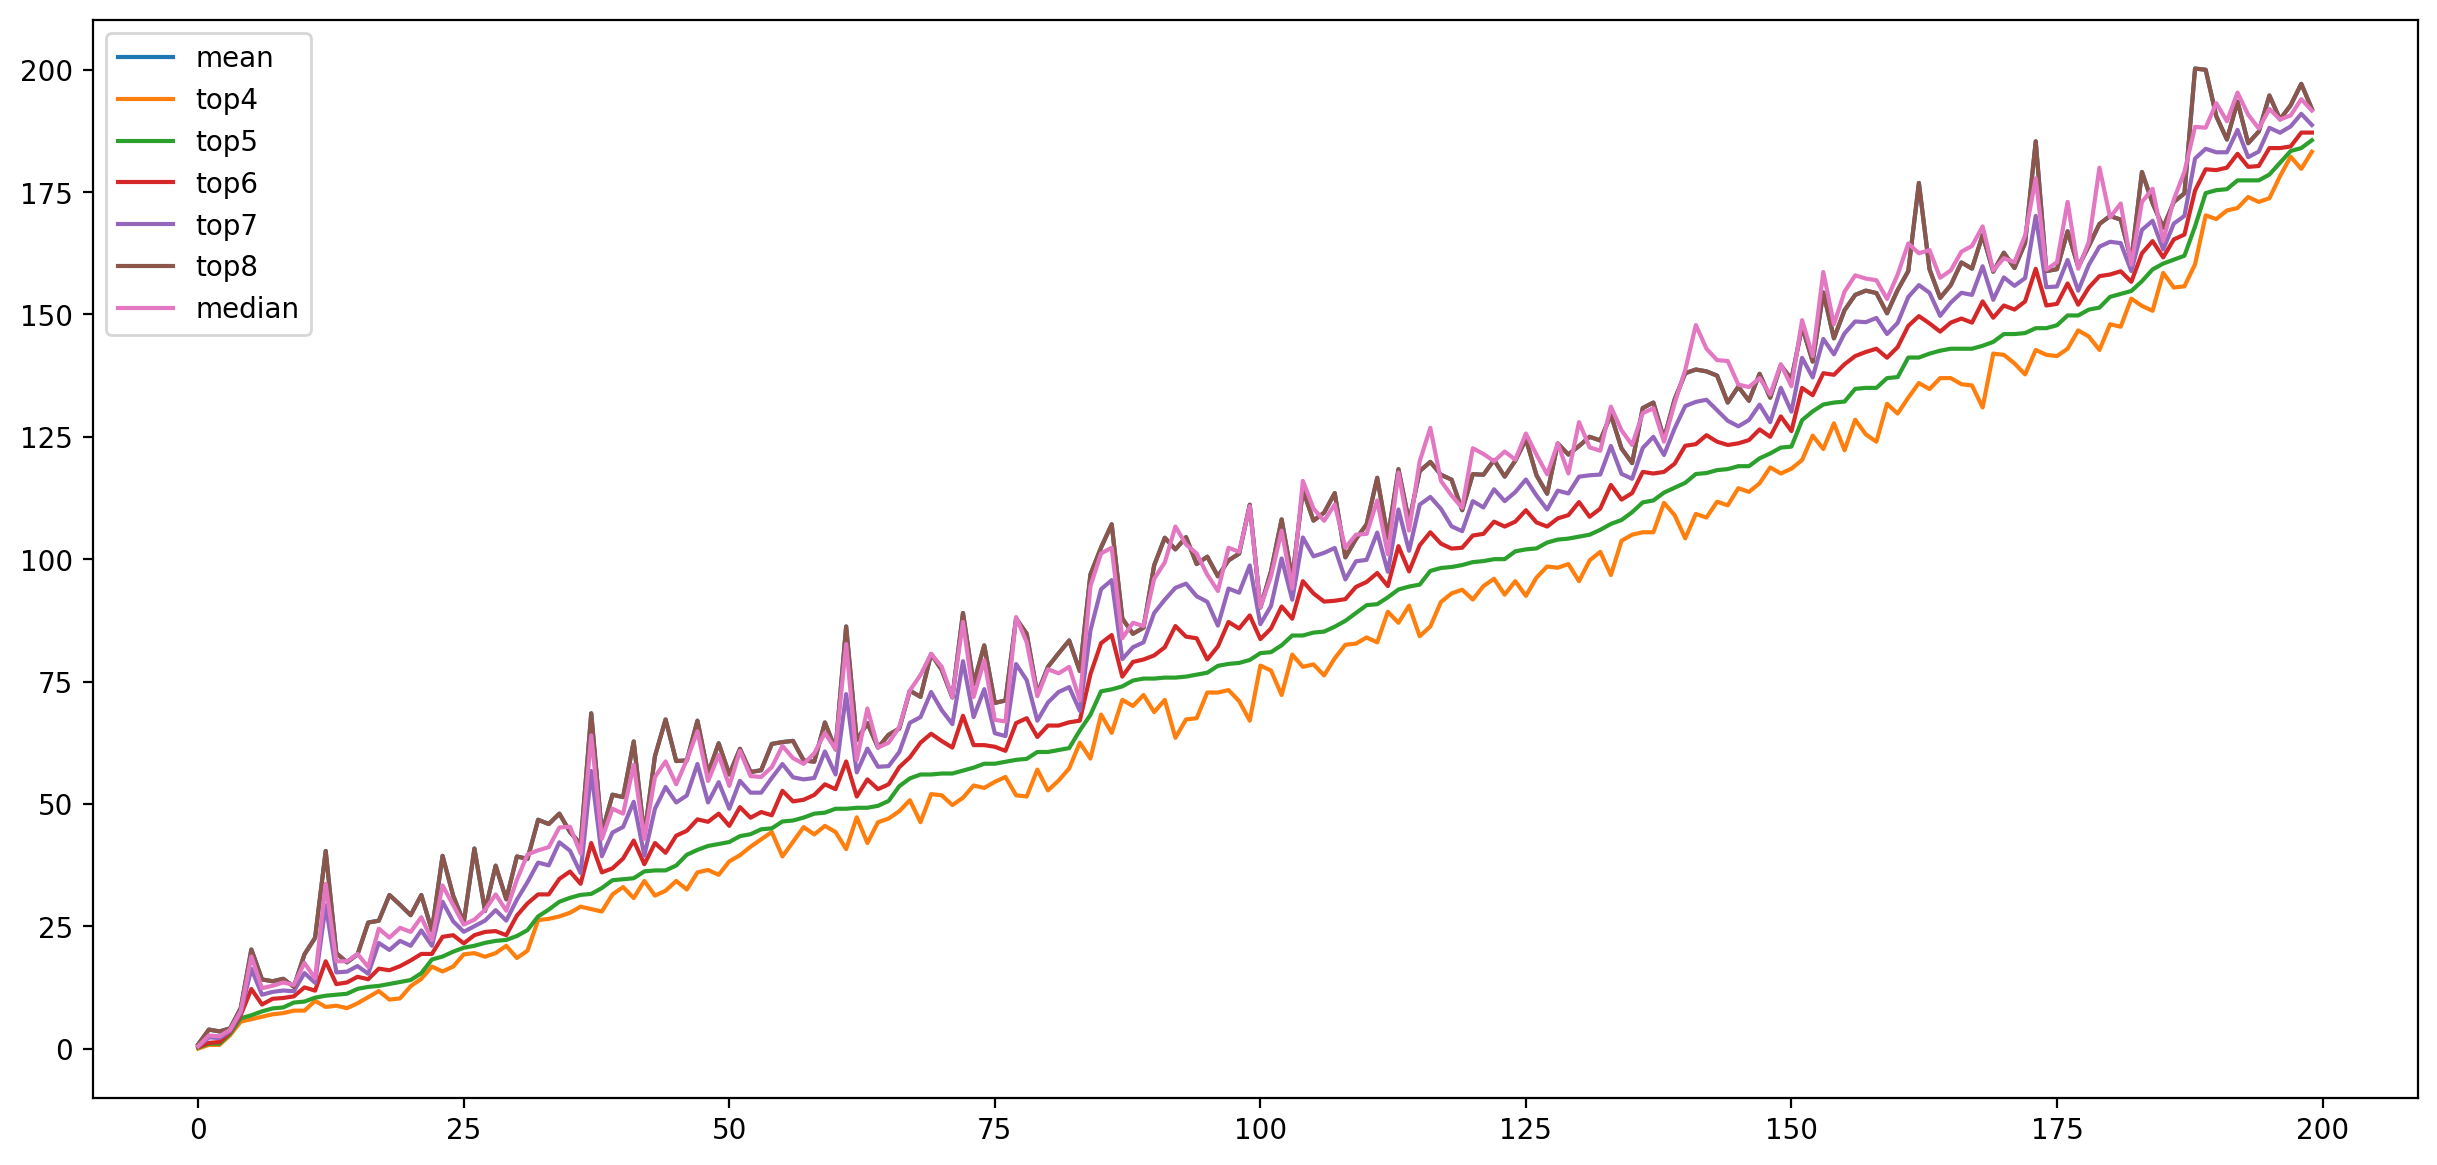

In [10]:
df[["mean", "top4", "top5", "top6", "top7", "top8", "median"]].sort_values(
    "top5"
).reset_index(drop=True).head(200).plot(figsize=(15, 7))
plt.show();

In [145]:
save_submission(
    avg_submission["top5"], "/app/_data/artist_data/ens_submissions/", "top5_v1.txt"
)

In [146]:
save_submission(
    avg_submission["top6"], "/app/_data/artist_data/ens_submissions/", "top6_v1.txt"
)

In [147]:
save_submission(
    avg_submission["top3"], "/app/_data/artist_data/ens_submissions/", "top3_v0.txt"
)

In [148]:
save_submission(
    avg_submission["mid"], "/app/_data/artist_data/ens_submissions/", "mid_v0.txt"
)

## Ensemble models

In [4]:
feature_loader = FeaturesLoader(
    features_dir_path=test_dir, meta_info=test, device=device, crop_size=60
)

In [5]:
test_loader = TestLoader(
    features_loader=feature_loader, batch_size=256, features_size=(512, 60)
)

In [7]:
mod_paths = glob.glob(os.path.join(mod_dir, "*_1_*"))
mod_paths

['/app/_data/artist_data/baseline/ny_1_2',
 '/app/_data/artist_data/baseline/ny_1_0',
 '/app/_data/artist_data/baseline/ny_1_1',
 '/app/_data/artist_data/baseline/ny_1_5',
 '/app/_data/artist_data/baseline/ny_1_4',
 '/app/_data/artist_data/baseline/ny_1_3']

In [12]:
def load_model(path, device):
    weights = torch.load(os.path.join(path, "best.pt"))
    with open(os.path.join(path, "args.json"), "r") as f:
        cfg = json.load(f)
    model = BasicNet(cfg["n_chahels"], kernel_size=5)
    model.load_state_dict(weights)
    model.eval()
    model.to(device)
    return model

In [13]:
submissions = []
for m_path in mod_paths:
    model = load_model(path=m_path, device=device)
    embeds = inference(model, test_loader)
    submission = get_ranked_list(embeds, 1010, 128)
    submissions.append(submission)

100% 41377/41377 [00:20<00:00, 2057.54it/s]
100% 41377/41377 [00:04<00:00, 8687.46it/s]
100% 41377/41377 [06:30<00:00, 105.88it/s]
100% 41377/41377 [00:17<00:00, 2354.54it/s]
100% 41377/41377 [00:04<00:00, 9106.47it/s]
100% 41377/41377 [06:35<00:00, 104.51it/s]
100% 41377/41377 [00:19<00:00, 2162.71it/s]
100% 41377/41377 [00:04<00:00, 8652.47it/s]
100% 41377/41377 [06:33<00:00, 105.11it/s]
100% 41377/41377 [00:18<00:00, 2297.90it/s]
100% 41377/41377 [00:04<00:00, 8572.38it/s]
100% 41377/41377 [06:37<00:00, 104.12it/s]
100% 41377/41377 [00:18<00:00, 2276.30it/s]
100% 41377/41377 [00:04<00:00, 8535.12it/s]
100% 41377/41377 [06:37<00:00, 104.12it/s]
100% 41377/41377 [00:17<00:00, 2310.80it/s]
100% 41377/41377 [00:04<00:00, 8590.08it/s]
100% 41377/41377 [06:38<00:00, 103.78it/s]


In [14]:
len(submissions[0])

41377

In [126]:
avg_submission = {"top4": {}, "top6": {}, "top3": {}, "mid": {}}
for trackid in tqdm(test["trackid"].tolist()[:10]):
    track_ranks = {}

    all_tracks = np.zeros([6, 1000])
    for i in range(len(submissions)):
        all_tracks[i] = submissions[i][trackid]
    values, counts = np.unique(
        all_tracks,
        return_index=False,
        return_inverse=False,
        return_counts=True,
    )
    df = pd.DataFrame()
    values = values[counts >= 3]

    for v in range(values.shape[0]):
        rank = np.argwhere(all_tracks == values[v])[:, 1]
        df.loc[v, "trackid"] = values[v]
        df.loc[v, "ids"] = " ".join(list(map(str, np.sort(rank))))
        df.loc[v, "count"] = rank.shape[0]
        df.loc[v, "mean_rank"] = rank.mean()
        df.loc[v, "top4_rank"] = " ".join(list(map(str, np.sort(rank)[:4])))
        df.loc[v, "top4_mean"] = np.sort(rank)[:4].mean()
        df.loc[v, "top3_mean"] = np.sort(rank)[:3].mean()
        df.loc[v, "bottom4_mean"] = np.sort(rank)[-4:].mean()
        if rank.shape[0] >= 4:
            df.loc[v, "median4_mean"] = np.sort(rank)[1:-1].mean()
        else:
            df.loc[v, "median4_mean"] = rank.mean()
    df["trackid"] = df["trackid"].astype("int")
    avg_submission["top4"][trackid] = (
        df.sort_values(by=["top4_mean", "mean_rank"]).head(100)["trackid"].tolist()
    )
    avg_submission["top6"][trackid] = (
        df.sort_values(by=["mean_rank", "top4_mean"]).head(100)["trackid"].tolist()
    )
    avg_submission["top3"][trackid] = (
        df.sort_values(by=["top3_mean", "mean_rank"]).head(100)["trackid"].tolist()
    )
    avg_submission["mid"][trackid] = (
        df.sort_values(by=["median4_mean", "mean_rank"]).head(100)["trackid"].tolist()
    )

100% 10/10 [00:14<00:00,  1.47s/it]


In [140]:
# for trackid in tqdm(test["trackid"].tolist()):
#     track_ranks = {}

#     all_tracks = np.zeros([6, 1000])
#     for i in range(len(submissions)):
#         if len(submissions[i][trackid])<1000:
#             print(i, trackid)
#             submissions[i][trackid].append(0)
#         all_tracks[i] = submissions[i][trackid]

In [141]:
avg_submission = {"top4": {}, "top6": {}, "top3": {}, "mid": {}}
for trackid in tqdm(test["trackid"].tolist()):
    track_ranks = {}

    all_tracks = np.zeros([6, 1000])
    for i in range(len(submissions)):
        if len(submissions[i][trackid]) < 1000:
            submissions[i][trackid].append(0)
        all_tracks[i] = submissions[i][trackid]
    values, counts = np.unique(
        all_tracks,
        return_index=False,
        return_inverse=False,
        return_counts=True,
    )
    values = values[counts >= 3]
    names = ["trackid", "count", "mean", "top4", "top3", "mid"]
    arr = np.zeros([values.shape[0], 6])

    for v in range(values.shape[0]):
        rank = np.argwhere(all_tracks == values[v])[:, 1]
        arr[v, 0] = values[v]  # trackid
        arr[v, 1] = rank.shape[0]  # count
        arr[v, 2] = rank.mean()  # mean
        arr[v, 3] = np.sort(rank)[:4].mean()  # top4
        arr[v, 4] = np.sort(rank)[:3].mean()  # top3
        arr[v, 5] = np.sort(rank)[1:-1].mean()  # mid
    avg_submission["top4"][trackid] = arr[
        np.lexsort((arr[:, names.index("mean")], arr[:, names.index("top4")]))
    ][:, 0][:100].astype("int")
    avg_submission["top6"][trackid] = arr[
        np.lexsort((arr[:, names.index("top4")], arr[:, names.index("mean")]))
    ][:, 0][:100].astype("int")
    avg_submission["top3"][trackid] = arr[
        np.lexsort((arr[:, names.index("mean")], arr[:, names.index("top3")]))
    ][:, 0][:100].astype("int")
    avg_submission["mid"][trackid] = arr[
        np.lexsort((arr[:, names.index("mean")], arr[:, names.index("mid")]))
    ][:, 0][:100].astype("int")

100% 41377/41377 [1:13:16<00:00,  9.41it/s]


In [131]:
avg_submission["top4"][trackid][:100]

array([194434, 181321, 188900, 199442, 176469, 185931, 188693, 194925,
       191575, 196986, 183247, 179932, 175885, 177159, 198676, 173070,
       199787, 194672, 174862, 182803, 202039, 205513, 173463, 207061,
       190368, 192377, 200869, 169249, 207179, 202554, 205272, 170971,
       189104, 187284, 192187, 172073, 203518, 194997, 178826, 183976,
       202928, 198478, 170628, 191265, 181566, 168547, 173509, 183023,
       172253, 184930, 193376, 195566, 191488, 175757, 179028, 192669,
       177187, 208534, 183839, 194127, 207704, 202932, 172010, 208058,
       189889, 191957, 183925, 178206, 195203, 185746, 181462, 192242,
       174151, 198375, 174745, 186397, 184360, 188417, 172918, 197612,
       183798, 189495, 171289, 197744, 199339, 196314, 198877, 179831,
       199533, 182554, 172741, 177757, 184810, 197017, 204250, 197190,
       187796, 172147, 203904, 206860])

<AxesSubplot:>

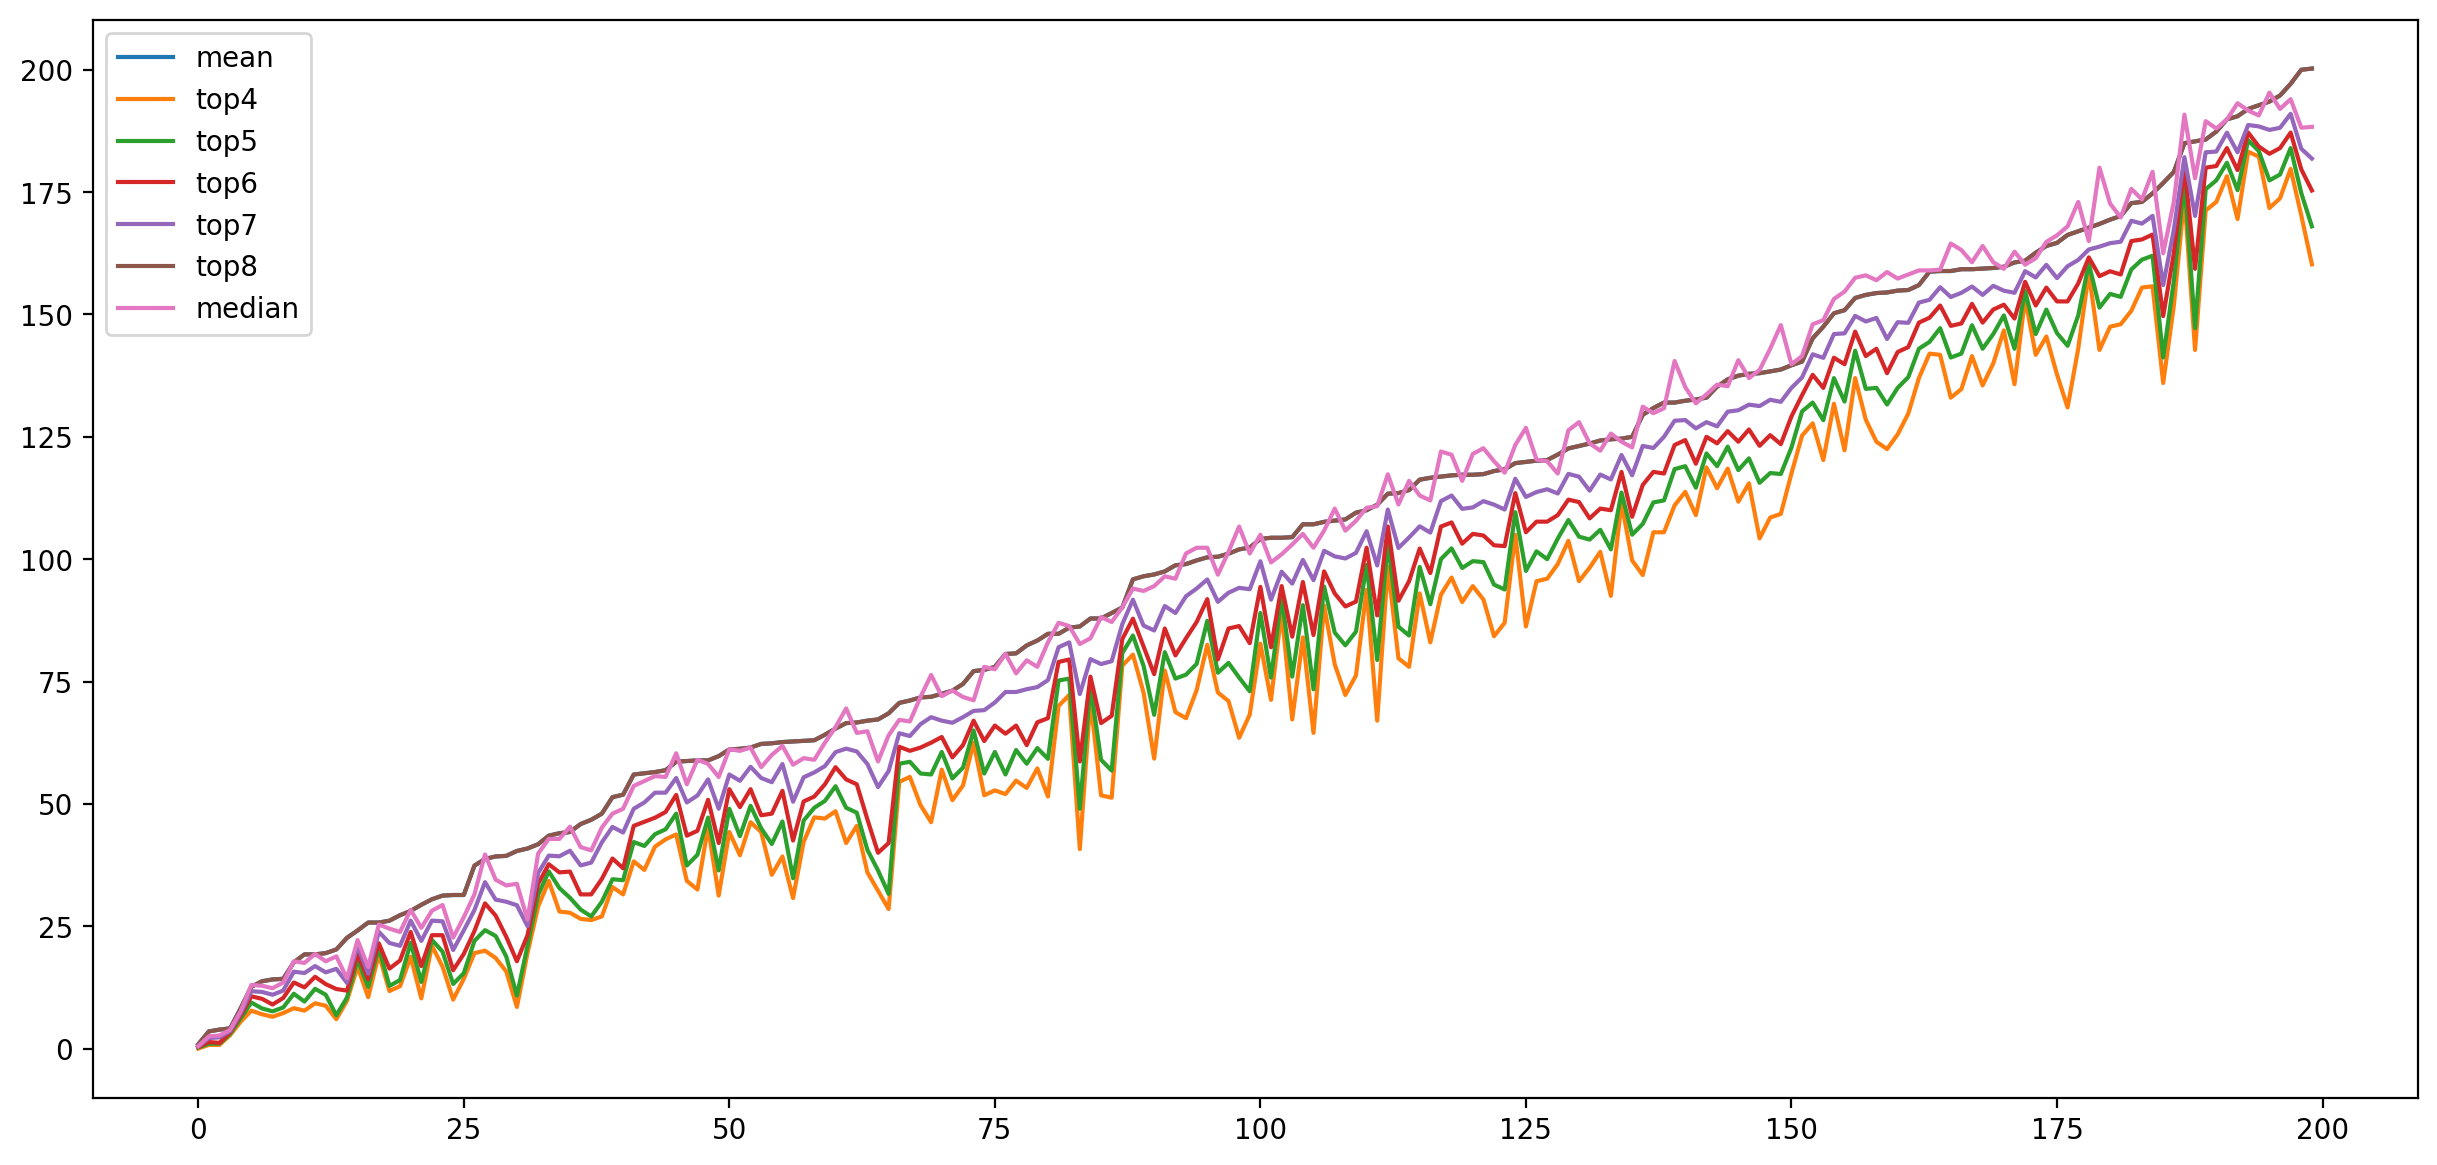

In [9]:
df[["mean", "top4", "top5", "top6", "top7", "top8", "median"]].sort_values(
    "mean"
).reset_index(drop=True).head(200).plot(figsize=(15, 7))
plt.show()

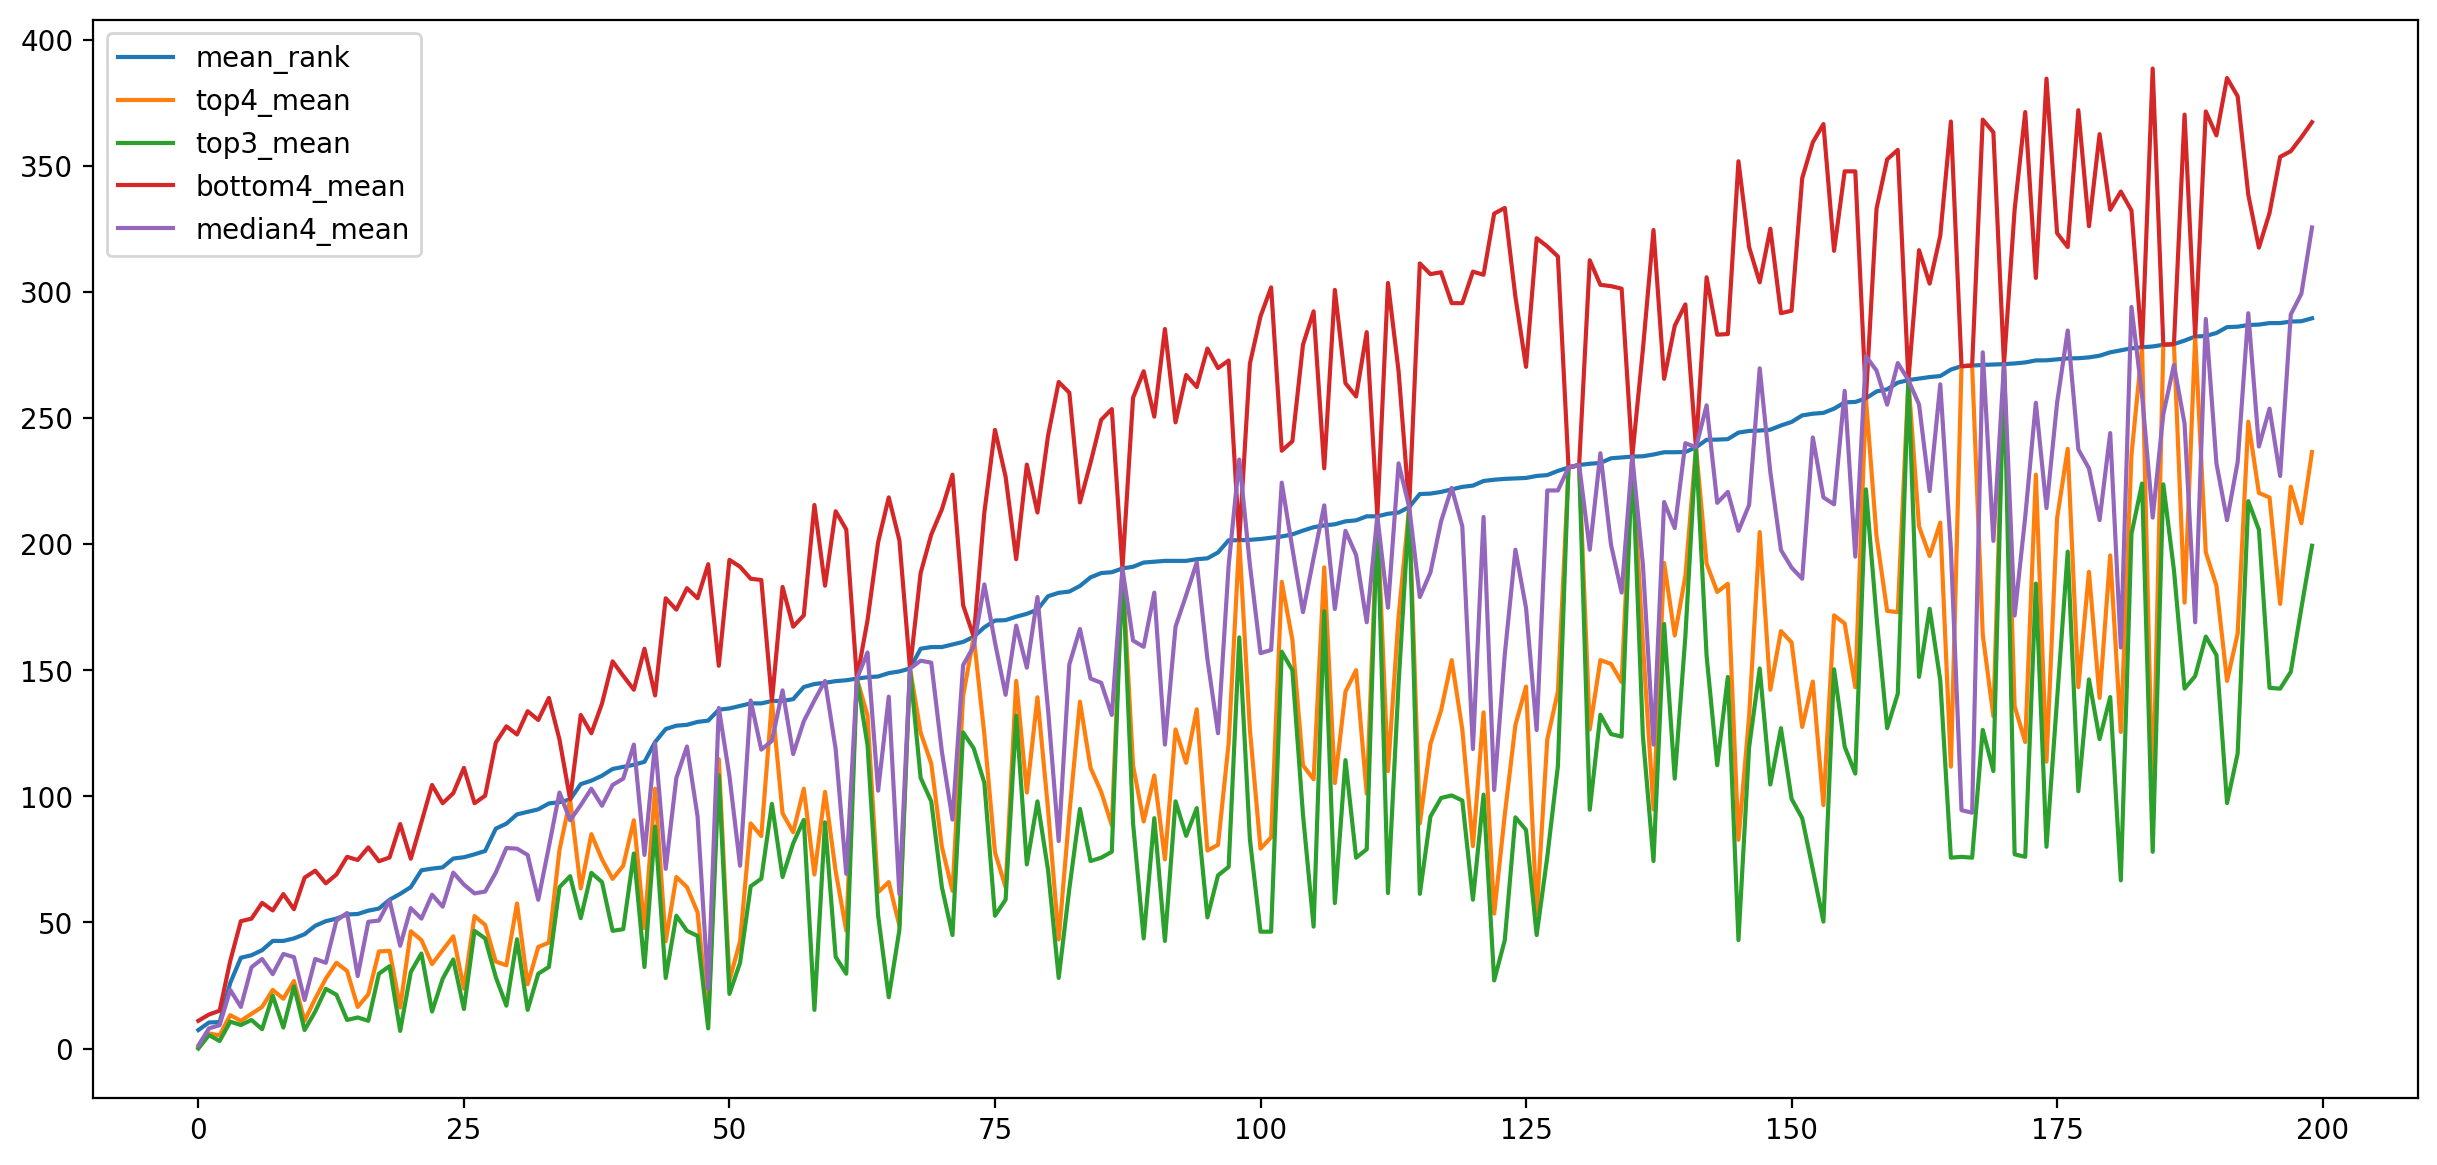

In [19]:
df[["mean_rank", "top4_mean", "top3_mean", "bottom4_mean", "median4_mean"]].sort_values(
    "mean_rank"
).reset_index(drop=True).head(200).plot(figsize=(15, 7))
plt.show()

In [145]:
df.columns

Index(['trackid', 'ids', 'count', 'mean_rank', 'top4_rank', 'top4_mean',
       'top3_mean', 'bottom4_mean', 'median4_mean'],
      dtype='object')

In [137]:
df.head(100)["count"].unique()

array([6., 5., 4.])

In [112]:
df.query("mean_rank<100")

,trackid,ids,count,mean_rank,top4_rank,top4_mean
0,167448.0,0 0 0 2 3 39,6.0,7.333333,0 0 0 2,0.50
1,181405.0,1 2 6 12 17 25,6.0,10.500000,1 2 6 12,5.25
2,199717.0,2 6 8 8 10 28,6.0,10.333333,2 6 8 8,6.00
3,204599.0,3 11 14 16 25 147,6.0,36.000000,3 11 14 16,11.00
4,192747.0,0 1 21 22 33 195,6.0,45.333333,0 1 21 22,11.00
6,204656.0,8 9 15 21 48 55,6.0,26.000000,8 9 15 21,13.25
7,200393.0,2 14 18 21 76 91,6.0,37.000000,2 14 18 21,13.75
8,169833.0,5 7 9 44 103 200,6.0,61.333333,5 7 9 44,16.25
9,184916.0,1 2 20 43 77 91,6.0,39.000000,1 2 20 43,16.50
10,167240.0,6 15 16 29 55 199,6.0,53.333333,6 15 16 29,16.50


In [38]:
values, ids, inv_idx, counts = np.unique(
    all_tracks, return_index=True, return_inverse=True, return_counts=True, axis=None
)

In [39]:
ids

array([1663,    6, 2595, ...,   40,  724, 2405])

In [40]:
counts

array([1, 6, 2, ..., 4, 2, 2])

In [43]:
values[counts > 5].shape

(245,)

In [44]:
inv_idx

array([1790, 1385,   19, ..., 2069,  547, 1900])

In [ ]:
embeds = inference(model, test_loader)
    submission = get_ranked_list(embeds, 100)
    save_submission(submission, SUBMISSION_PATH)
    torch.save(sim_clr.state_dict(), MODEL_PATH)

In [11]:
embeds = inference(model, test_loader)

100% 41377/41377 [00:23<00:00, 1752.71it/s]


In [12]:
submission = get_ranked_list(embeds, 100, 256)

In [28]:
# submission

In [16]:
def choose_100(prediction, df, path_to_save=mod_dir, file_ix=1, n_samples=100):
    def pairwise_distances_np(array):
        dists = (
            np.sum(np.square(array), axis=1, keepdims=True)
            + np.sum(np.square(np.transpose(array, (1, 0))), axis=0, keepdims=True)
            - 2.0 * np.matmul(array, np.transpose(array, (1, 0)))
        )
        return dists

    dists = pairwise_distances_np(prediction)
    neigh = {}
    # with open(os.path.join(path_to_save, f"submission_{file_ix}"), "w") as f:
    for ix in tqdm(range(prediction.shape[0])):
        trackid = df.loc[ix, "trackid"]
        nearest_100 = np.argsort(dists[ix])[: n_samples + 1]
        tracks_100 = df.loc[nearest_100, "trackid"].tolist()
        neigh[trackid] = {"tracks": [x for x in tracks_100 if x != trackid]}
        # f.write(
        #     "{}\t{}\n".format(
        #         trackid,
        #         " ".join(list(map(str, tracks_100))),
        #     )
        # )
    return neigh

In [ ]:
def get_ranked_list(embeds, top_size, annoy_num_trees=32):
    annoy_index = None
    annoy2id = []
    id2annoy = dict()
    for track_id, track_embed in embeds.items():
        id2annoy[track_id] = len(annoy2id)
        annoy2id.append(track_id)
        if annoy_index is None:
            annoy_index = annoy.AnnoyIndex(len(track_embed), "angular")
        annoy_index.add_item(id2annoy[track_id], track_embed)
    annoy_index.build(annoy_num_trees)
    ranked_list = dict()
    for track_id in embeds.keys():
        candidates = annoy_index.get_nns_by_item(id2annoy[track_id], top_size + 1)[
            1:
        ]  # exclude trackid itself
        candidates = list(filter(lambda x: x != id2annoy[track_id], candidates))
        ranked_list[track_id] = [annoy2id[candidate] for candidate in candidates]
    return ranked_list

In [13]:
def my_inference(model, loader):
    embeds = []
    for tracks_ids, tracks_features in loader:
        with torch.no_grad():
            tracks_embeds = model(tracks_features)
            embeds.extend(tracks_embeds.cpu().numpy())
    return np.array(embeds)

In [14]:
preds = my_inference(model, test_loader)

100% 41377/41377 [00:18<00:00, 2223.53it/s]


In [17]:
neigh = choose_100(
    prediction=preds, df=test, path_to_save=mod_dir, file_ix=1, n_samples=100
)

100% 41377/41377 [02:32<00:00, 271.15it/s]


In [20]:
submission[167197][:10]

[167448,
 184916,
 181405,
 207057,
 169274,
 193221,
 179598,
 169833,
 199717,
 175015]

In [21]:
neigh[167197]["tracks"][:10]

[167448,
 199717,
 181458,
 179917,
 185595,
 191314,
 175664,
 202789,
 207057,
 186842]

In [22]:
[x for x in submission[167197] if x in neigh[167197]["tracks"]]

[167448,
 184916,
 207057,
 169274,
 169833,
 199717,
 204599,
 179917,
 181458,
 200904,
 204656,
 175664,
 191901,
 185595,
 191314,
 178480,
 202789,
 208461,
 168509,
 204420,
 193276,
 186842,
 204636,
 199503,
 179343,
 194156,
 202114,
 177306,
 179856,
 183692]